<a href="https://colab.research.google.com/github/seanpaz478/AAI511_Final_Project_Group1/blob/fp2/final-project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install pretty_midi kagglehub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 52.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 5.5 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592286 sha256=24e6bd0379e42cacc78206117b0fb707d41cf52d77ff51784302554c80cb5a71
  Stored in directory: /root/.cache/pip/wheels/e6/95/ac/15ceaeb2823b04d8e638fd1495357adb8d26c00ccac9d7782e
Successfully built pretty_midi


In [2]:
import os
import kagglehub
import zipfile
import shutil
import numpy as np
import torch
import torch.nn as nn
import os
import numpy as np
import pretty_midi
import torch
from torch.utils.data import Dataset

In [3]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [4]:
if not hasattr(np, 'int'):
    np.int = int

In [5]:
TARGET_COMPOSERS = [
    'Bach',
    'Beethoven',
    'Chopin',
    'Mozart',
]

path = kagglehub.dataset_download("blanderbuss/midi-classic-music")

zip_path = os.path.join(path, 'midiclassics.zip')
extract_path = os.path.join('data', 'kaggle', 'midiclassics')


with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# list files in extract_path that contain the target composers in name
for composer in TARGET_COMPOSERS:
    composer_files = [f for f in os.listdir(extract_path) if composer.lower() in f.lower()]

# Only keep directories that contain a target composer's name
for item in os.listdir(extract_path):
    item_path = os.path.join(extract_path, item)
    if not any(composer.lower() in item.lower() for composer in TARGET_COMPOSERS):
        if os.path.isfile(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

# also delete "C.P.E.Bach" files. This was the son of J.S. Bach, and we want to keep only the main composers
for item in os.listdir(extract_path):
    if 'C.P.E.Bach' in item:
        item_path = os.path.join(extract_path, item)
        if os.path.isfile(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

In [6]:
class PianoRollDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        # Add channel dimension for CNN: (1, 128, T)
        return self.data[idx].unsqueeze(0), self.labels[idx]

In [7]:
def get_piano_roll_improved(midi_path, fs=100, target_duration=45.0):
    """
    Improved MIDI to piano roll conversion with musical awareness
    """
    try:
        pm = pretty_midi.PrettyMIDI(midi_path)

        # Get the actual duration of the piece
        actual_duration = pm.get_end_time()

        # If piece is very short, skip it
        if actual_duration < 10.0:  # Less than 10 seconds
            return None

        # For long pieces, extract multiple segments
        if actual_duration > target_duration * 1.5:
            # Extract from different parts of the piece
            segments = []
            num_segments = min(3, int(actual_duration // target_duration))

            for i in range(num_segments):
                start_time = i * (actual_duration / num_segments)
                end_time = start_time + target_duration

                # Create a copy and trim
                pm_segment = pretty_midi.PrettyMIDI()
                for instrument in pm.instruments:
                    new_instrument = pretty_midi.Instrument(
                        program=instrument.program,
                        is_drum=instrument.is_drum,
                        name=instrument.name
                    )

                    for note in instrument.notes:
                        if start_time <= note.start < end_time:
                            new_note = pretty_midi.Note(
                                velocity=note.velocity,
                                pitch=note.pitch,
                                start=note.start - start_time,
                                end=min(note.end - start_time, target_duration)
                            )
                            new_instrument.notes.append(new_note)

                    if new_instrument.notes:
                        pm_segment.instruments.append(new_instrument)

                if pm_segment.instruments:
                    piano_roll = pm_segment.get_piano_roll(fs=fs)
                    target_length = int(target_duration * fs)

                    if piano_roll.shape[1] > target_length:
                        piano_roll = piano_roll[:, :target_length]
                    else:
                        pad_width = target_length - piano_roll.shape[1]
                        piano_roll = np.pad(piano_roll, ((0,0),(0,pad_width)), mode='constant')

                    segments.append(piano_roll)

            return segments

        else:
            # For normal length pieces, use the whole piece
            piano_roll = pm.get_piano_roll(fs=fs)
            target_length = int(target_duration * fs)

            if piano_roll.shape[1] > target_length:
                # Take from the middle rather than truncating end
                start_idx = (piano_roll.shape[1] - target_length) // 2
                piano_roll = piano_roll[:, start_idx:start_idx + target_length]
            else:
                pad_width = target_length - piano_roll.shape[1]
                piano_roll = np.pad(piano_roll, ((0,0),(0,pad_width)), mode='constant')

            return [piano_roll]

    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return None


In [8]:
def normalize_piano_roll(piano_roll):
    """
    Apply musical normalization to piano roll
    """
    # 1. Velocity normalization (already 0-1 from pretty_midi)
    normalized = piano_roll.copy()

    # 2. Optional: Focus on active pitch range
    active_pitches = np.any(normalized > 0, axis=1)
    if np.any(active_pitches):
        first_active = np.argmax(active_pitches)
        last_active = len(active_pitches) - 1 - np.argmax(active_pitches[::-1])

        # Ensure we keep a reasonable range (at least 60 semitones = 5 octaves)
        min_range = 60
        current_range = last_active - first_active + 1

        if current_range < min_range:
            expand = (min_range - current_range) // 2
            first_active = max(0, first_active - expand)
            last_active = min(127, last_active + expand)

    return normalized


In [9]:
def extract_musical_features(piano_roll):
    """
    Extract features that capture musical style
    """
    features = {}

    # Temporal features
    note_density_timeline = np.sum(piano_roll > 0, axis=0)
    features['avg_notes_per_time'] = np.mean(note_density_timeline)
    features['note_density_variance'] = np.var(note_density_timeline)

    # Pitch features
    pitch_activity = np.sum(piano_roll > 0, axis=1)
    active_pitches = pitch_activity > 0
    if np.any(active_pitches):
        features['pitch_range'] = np.sum(active_pitches)
        features['lowest_pitch'] = np.argmax(active_pitches)
        features['highest_pitch'] = 127 - np.argmax(active_pitches[::-1])
    else:
        features['pitch_range'] = 0
        features['lowest_pitch'] = 60  # Middle C
        features['highest_pitch'] = 60

    # Rhythmic features
    onset_pattern = np.diff(note_density_timeline > 0).astype(int)
    features['onset_density'] = np.sum(onset_pattern == 1) / len(onset_pattern)

    return features

print("✅ Improved data processing functions defined!")
print("Key improvements:")
print("• Intelligent segment extraction for long pieces")
print("• Musical boundary awareness")
print("• Better normalization")
print("• Feature extraction for analysis")

✅ Improved data processing functions defined!
Key improvements:
• Intelligent segment extraction for long pieces
• Musical boundary awareness
• Better normalization
• Feature extraction for analysis


In [13]:
# =====================================================
# IMPROVED DATA LOADING WITH BETTER PROCESSING
# =====================================================

import numpy as np

def load_improved_dataset(extract_path, target_composers, target_duration=45.0, max_files_per_composer=None):
    """
    Load dataset with improved processing that addresses previous shortcomings
    """
    print("🎵 LOADING DATASET WITH IMPROVED PROCESSING...")
    print("Improvements over original:")
    print("• Intelligent segment extraction for long pieces")
    print("• Better handling of piece lengths")
    print("• Musical feature extraction")
    print("• Quality filtering")

    composer_to_idx = {c: i for i, c in enumerate(target_composers)}
    all_data = []
    all_labels = []
    all_features = []

    for composer in target_composers:
        print(f"\n--- Processing {composer} ---")
        composer_dir = os.path.join(extract_path, composer)

        if not os.path.isdir(composer_dir):
            print(f"Directory not found: {composer_dir}")
            continue

        composer_data = []
        composer_labels = []
        composer_features = []
        files_processed = 0
        segments_created = 0

        midi_files = [f for f in os.listdir(composer_dir)
                     if f.lower().endswith(('.mid', '.midi'))]

        if max_files_per_composer:
            midi_files = midi_files[:max_files_per_composer]

        for file in midi_files:
            midi_path = os.path.join(composer_dir, file)

            try:
                # Use improved processing
                segments = get_piano_roll_improved(midi_path, target_duration=target_duration)

                if segments is None:
                    continue

                for segment in segments:
                    # Normalize the segment
                    normalized_segment = normalize_piano_roll(segment)

                    # Extract musical features
                    features = extract_musical_features(normalized_segment)

                    # Quality check: skip if too sparse
                    note_density = features['avg_notes_per_time']
                    if note_density < 0.1:  # Very sparse, likely poor quality
                        continue

                    composer_data.append(normalized_segment)
                    composer_labels.append(composer_to_idx[composer])
                    composer_features.append(features)
                    segments_created += 1

                files_processed += 1

                if files_processed % 10 == 0:
                    print(f"  Processed {files_processed} files, created {segments_created} segments...")

            except Exception as e:
                print(f"  Error processing {file}: {e}")
                continue

        print(f"✅ {composer}: {files_processed} files → {segments_created} segments")

        if composer_data:
            composer_data = np.array(composer_data)
            composer_labels = np.array(composer_labels)

            all_data.append(composer_data)
            all_labels.append(composer_labels)
            all_features.extend(composer_features)

            print(f"  Final data shape: {composer_data.shape}")

    # Combine all data
    if all_data:
        data = np.concatenate(all_data, axis=0)
        labels = np.concatenate(all_labels, axis=0)

        print(f"\n🎯 FINAL IMPROVED DATASET:")
        print(f"Total samples: {len(data)}")
        print(f"Data shape: {data.shape}")
        print(f"Label distribution: {np.bincount(labels)}")

        return data, labels, all_features
    else:
        print("❌ No data loaded!")
        return None, None, None

# Load the improved dataset
print("🚀 Starting improved data loading...")
improved_data, improved_labels, features = load_improved_dataset(
    extract_path,
    TARGET_COMPOSERS,
    target_duration=45.0,  # 45 seconds per segment
    max_files_per_composer=120  # Limit for testing - remove for full dataset
)

🚀 Starting improved data loading...
🎵 LOADING DATASET WITH IMPROVED PROCESSING...
Improvements over original:
• Intelligent segment extraction for long pieces
• Better handling of piece lengths
• Musical feature extraction
• Quality filtering

--- Processing Bach ---
  Processed 10 files, created 28 segments...
  Processed 20 files, created 52 segments...
  Processed 30 files, created 82 segments...
  Processed 40 files, created 104 segments...
  Processed 50 files, created 131 segments...
  Processed 60 files, created 157 segments...
  Processed 70 files, created 182 segments...
  Processed 80 files, created 209 segments...
  Processed 90 files, created 236 segments...
  Processed 100 files, created 260 segments...
  Processed 110 files, created 286 segments...
  Processed 120 files, created 312 segments...
✅ Bach: 120 files → 312 segments
  Final data shape: (312, 128, 4500)

--- Processing Beethoven ---
  Processed 10 files, created 22 segments...
Error processing data/kaggle/midicl

In [14]:
# =====================================================
# IMPROVED NON-OVERLAPPING SEGMENTATION
# =====================================================

from collections import defaultdict

def balance_classes_song_aware(segments_by_composer, target_samples_per_class=None):
    """
    Balance classes by selecting complete songs (with all their segments)
    This preserves temporal relationships within songs
    """
    # Calculate current distribution
    composer_counts = {composer: len(segments) for composer, segments in segments_by_composer.items()}
    max_count = max(composer_counts.values()) if target_samples_per_class is None else target_samples_per_class

    print(f"📊 Original segment distribution: {composer_counts}")
    print(f"🎯 Target segments per class: {max_count}")

    balanced_segments = {}

    for composer, segments in segments_by_composer.items():
        current_count = len(segments)

        if current_count >= max_count:
            # If we have enough, randomly select songs to reach target
            songs_dict = defaultdict(list)
            for segment in segments:
                songs_dict[segment['song_id']].append(segment)

            # Randomly select songs until we reach target count
            selected_segments = []
            song_ids = list(songs_dict.keys())
            np.random.shuffle(song_ids)

            for song_id in song_ids:
                song_segments = songs_dict[song_id]
                if len(selected_segments) + len(song_segments) <= max_count:
                    selected_segments.extend(song_segments)
                elif len(selected_segments) < max_count:
                    # Partial song - take contiguous segments from the beginning
                    needed = max_count - len(selected_segments)
                    selected_segments.extend(song_segments[:needed])
                    break

            balanced_segments[composer] = selected_segments
            print(f"  {composer}: {current_count} → {len(selected_segments)} (downsampled)")

        else:
            # Need to oversample - duplicate entire songs
            needed_samples = max_count - current_count

            # Group segments by song
            songs_dict = defaultdict(list)
            for segment in segments:
                songs_dict[segment['song_id']].append(segment)

            song_ids = list(songs_dict.keys())
            selected_segments = segments.copy()  # Start with all original segments

            # Add complete songs until we reach target
            while len(selected_segments) < max_count:
                # Randomly select a song to duplicate
                song_id = np.random.choice(song_ids)
                song_segments = songs_dict[song_id]

                if len(selected_segments) + len(song_segments) <= max_count:
                    # Add entire song
                    for segment in song_segments:
                        # Create a copy with new metadata to avoid conflicts
                        new_segment = segment.copy()
                        new_segment['song_id'] = f"{segment['song_id']}_dup_{len(selected_segments)}"
                        selected_segments.append(new_segment)
                else:
                    # Add partial song if needed
                    remaining = max_count - len(selected_segments)
                    for i, segment in enumerate(song_segments[:remaining]):
                        new_segment = segment.copy()
                        new_segment['song_id'] = f"{segment['song_id']}_dup_{len(selected_segments)}"
                        selected_segments.append(new_segment)
                    break

            balanced_segments[composer] = selected_segments
            print(f"  {composer}: {current_count} → {len(selected_segments)} (+{len(selected_segments) - current_count} from song duplication)")

    return balanced_segments

def get_piano_roll_segments_no_overlap(midi_path, fs=100, segment_duration=20.0):
    """
    Extract NON-OVERLAPPING segments from a single MIDI file
    This preserves temporal relationships without data leakage
    """
    try:
        pm = pretty_midi.PrettyMIDI(midi_path)
        actual_duration = pm.get_end_time()

        # Skip very short pieces
        if actual_duration < segment_duration:
            return None

        segments = []
        segment_length = int(segment_duration * fs)

        # Extract non-overlapping segments
        current_time = 0.0
        segment_idx = 0

        while current_time + segment_duration <= actual_duration:
            end_time = current_time + segment_duration

            # Create segment
            pm_segment = pretty_midi.PrettyMIDI()
            for instrument in pm.instruments:
                new_instrument = pretty_midi.Instrument(
                    program=instrument.program,
                    is_drum=instrument.is_drum,
                    name=instrument.name
                )

                for note in instrument.notes:
                    if current_time <= note.start < end_time:
                        new_note = pretty_midi.Note(
                            velocity=note.velocity,
                            pitch=note.pitch,
                            start=note.start - current_time,
                            end=min(note.end - current_time, segment_duration)
                        )
                        new_instrument.notes.append(new_note)

                if new_instrument.notes:
                    pm_segment.instruments.append(new_instrument)

            # Convert to piano roll
            if pm_segment.instruments:
                piano_roll = pm_segment.get_piano_roll(fs=fs)

                # Ensure exact length
                if piano_roll.shape[1] > segment_length:
                    piano_roll = piano_roll[:, :segment_length]
                elif piano_roll.shape[1] < segment_length:
                    pad_width = segment_length - piano_roll.shape[1]
                    piano_roll = np.pad(piano_roll, ((0,0),(0,pad_width)), mode='constant')

                # Store segment with metadata
                segment_info = {
                    'piano_roll': piano_roll,
                    'song_id': midi_path,
                    'segment_idx': segment_idx,
                    'start_time': current_time
                }
                segments.append(segment_info)
                segment_idx += 1

            # Move to next segment (NO OVERLAP)
            current_time += segment_duration  # Changed from (segment_duration - overlap)

        return segments if segments else None

    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return None

def load_segmented_dataset_no_overlap(extract_path, target_composers, segment_duration=20.0,
                                     max_files_per_composer=None, balance_classes=True):
    """
    Load dataset with NON-OVERLAPPING segmentation and balancing
    """
    print("🎵 LOADING DATASET WITH NON-OVERLAPPING SEGMENTATION...")
    print(f"Segment duration: {segment_duration}s with NO OVERLAP")
    print(f"Balance classes: {balance_classes}")

    composer_to_idx = {c: i for i, c in enumerate(target_composers)}
    segments_by_composer = {composer: [] for composer in target_composers}

    for composer in target_composers:
        print(f"\n--- Processing {composer} ---")
        composer_dir = os.path.join(extract_path, composer)

        if not os.path.isdir(composer_dir):
            print(f"Directory not found: {composer_dir}")
            continue

        files_processed = 0
        total_segments = 0

        midi_files = [f for f in os.listdir(composer_dir)
                     if f.lower().endswith(('.mid', '.midi'))]

        if max_files_per_composer:
            midi_files = midi_files[:max_files_per_composer]

        for file in midi_files:
            midi_path = os.path.join(composer_dir, file)

            try:
                # Extract NON-OVERLAPPING segments from this file
                segments = get_piano_roll_segments_no_overlap(
                    midi_path,
                    segment_duration=segment_duration
                )

                if segments is None:
                    continue

                # Process each segment
                valid_segments = []
                for segment_info in segments:
                    piano_roll = segment_info['piano_roll']

                    # Normalize the segment
                    normalized_segment = normalize_piano_roll(piano_roll)

                    # Extract musical features
                    features = extract_musical_features(normalized_segment)

                    # Quality check: skip if too sparse
                    note_density = features['avg_notes_per_time']
                    if note_density < 0.05:  # Very sparse, likely poor quality
                        continue

                    # Update segment info
                    segment_info['piano_roll'] = normalized_segment
                    segment_info['features'] = features
                    segment_info['label'] = composer_to_idx[composer]

                    valid_segments.append(segment_info)

                # Add valid segments to composer collection
                segments_by_composer[composer].extend(valid_segments)
                total_segments += len(valid_segments)
                files_processed += 1

                if files_processed % 10 == 0:
                    print(f"  Processed {files_processed} files, created {total_segments} segments...")

            except Exception as e:
                print(f"  Error processing {file}: {e}")
                continue

        print(f"✅ {composer}: {files_processed} files → {total_segments} segments")

    # Balance classes if requested
    if balance_classes:
        print(f"\n⚖️ BALANCING CLASSES (SONG-AWARE, NO OVERLAP)...")
        segments_by_composer = balance_classes_song_aware(segments_by_composer)

    # Convert to arrays
    all_data = []
    all_labels = []
    all_features = []

    for composer, segments in segments_by_composer.items():
        for segment_info in segments:
            all_data.append(segment_info['piano_roll'])
            all_labels.append(segment_info['label'])
            all_features.append(segment_info['features'])

    data = np.array(all_data)
    labels = np.array(all_labels)

    print(f"\n📊 FINAL BALANCED DATASET (NO OVERLAP):")
    print(f"Total samples: {len(data)}")
    print(f"Data shape: {data.shape}")
    final_counts = np.bincount(labels)
    for i, composer in enumerate(target_composers):
        if i < len(final_counts):
            print(f"  {composer}: {final_counts[i]} samples")

    return data, labels, all_features

# Load the NON-OVERLAPPING segmented and balanced dataset
print("🚀 Starting NON-OVERLAPPING segmented data loading...")
segmented_data, segmented_labels, segmented_features = load_segmented_dataset_no_overlap(
    extract_path,
    TARGET_COMPOSERS,
    segment_duration=20.0,      # 20-second segments
    max_files_per_composer=150, # More files since we get fewer segments per song
    balance_classes=True        # Enable song-aware class balancing
)

🚀 Starting NON-OVERLAPPING segmented data loading...
🎵 LOADING DATASET WITH NON-OVERLAPPING SEGMENTATION...
Segment duration: 20.0s with NO OVERLAP
Balance classes: True

--- Processing Bach ---
  Processed 10 files, created 186 segments...
  Processed 20 files, created 303 segments...
  Processed 30 files, created 559 segments...
  Processed 40 files, created 669 segments...
  Processed 50 files, created 809 segments...
  Processed 60 files, created 935 segments...
  Processed 70 files, created 1109 segments...
  Processed 80 files, created 1272 segments...
  Processed 90 files, created 1473 segments...
  Processed 100 files, created 1615 segments...
  Processed 110 files, created 1844 segments...
  Processed 120 files, created 2134 segments...
  Processed 130 files, created 2268 segments...
✅ Bach: 131 files → 2276 segments

--- Processing Beethoven ---
  Processed 10 files, created 150 segments...
Error processing data/kaggle/midiclassics/Beethoven/Anhang 14-3.mid: Could not decode 

In [15]:
# =====================================================
# ENHANCED MUSICAL FEATURE EXTRACTION FOR MULTIMODAL
# =====================================================

def extract_comprehensive_musical_features(piano_roll):
    """
    Extract comprehensive musical features for the MLP stream
    """
    features = {}

    # Get basic timeline and pitch data
    note_density_timeline = np.sum(piano_roll > 0, axis=0)
    pitch_activity = np.sum(piano_roll > 0, axis=1)
    active_pitches = pitch_activity > 0

    # ==========================================
    # TEMPORAL/RHYTHMIC FEATURES
    # ==========================================

    # Basic temporal statistics
    features['avg_notes_per_time'] = np.mean(note_density_timeline)
    features['note_density_variance'] = np.var(note_density_timeline)
    features['note_density_std'] = np.std(note_density_timeline)
    features['max_simultaneous_notes'] = np.max(note_density_timeline)

    # Rhythmic complexity
    onset_pattern = np.diff(note_density_timeline > 0).astype(int)
    features['onset_density'] = np.sum(onset_pattern == 1) / len(onset_pattern) if len(onset_pattern) > 0 else 0
    features['silence_ratio'] = np.sum(note_density_timeline == 0) / len(note_density_timeline)

    # Temporal distribution analysis
    active_frames = note_density_timeline > 0
    if np.any(active_frames):
        features['temporal_sparsity'] = 1 - (np.sum(active_frames) / len(active_frames))

        # Find note clusters (bursts of activity)
        cluster_changes = np.diff(active_frames.astype(int))
        features['activity_bursts'] = np.sum(cluster_changes == 1) / len(cluster_changes) if len(cluster_changes) > 0 else 0
    else:
        features['temporal_sparsity'] = 1.0
        features['activity_bursts'] = 0.0

    # ==========================================
    # PITCH/HARMONIC FEATURES
    # ==========================================

    if np.any(active_pitches):
        # Basic pitch statistics
        features['pitch_range'] = np.sum(active_pitches)
        features['lowest_pitch'] = np.argmax(active_pitches)
        features['highest_pitch'] = 127 - np.argmax(active_pitches[::-1])
        features['pitch_span'] = features['highest_pitch'] - features['lowest_pitch']

        # Pitch distribution
        weighted_pitches = np.arange(128) * pitch_activity
        total_weight = np.sum(pitch_activity)
        if total_weight > 0:
            features['pitch_centroid'] = np.sum(weighted_pitches) / total_weight
            features['pitch_variance'] = np.var(pitch_activity[active_pitches])
        else:
            features['pitch_centroid'] = 60  # Middle C
            features['pitch_variance'] = 0

        # Register analysis (musical ranges)
        bass_range = pitch_activity[21:48]  # A0 to B2
        mid_range = pitch_activity[48:72]   # C3 to B4
        treble_range = pitch_activity[72:108] # C5 to B7

        total_activity = np.sum(pitch_activity)
        features['bass_activity'] = np.sum(bass_range) / total_activity if total_activity > 0 else 0
        features['mid_activity'] = np.sum(mid_range) / total_activity if total_activity > 0 else 0
        features['treble_activity'] = np.sum(treble_range) / total_activity if total_activity > 0 else 0

    else:
        # Default values for empty piano rolls
        features.update({
            'pitch_range': 0, 'lowest_pitch': 60, 'highest_pitch': 60,
            'pitch_span': 0, 'pitch_centroid': 60, 'pitch_variance': 0,
            'bass_activity': 0, 'mid_activity': 0, 'treble_activity': 0
        })

    # ==========================================
    # HARMONIC COMPLEXITY FEATURES
    # ==========================================

    # Analyze simultaneous note patterns (chords vs single notes)
    chord_frames = note_density_timeline >= 3  # 3+ simultaneous notes = chord
    single_note_frames = note_density_timeline == 1

    features['chord_ratio'] = np.sum(chord_frames) / len(note_density_timeline)
    features['single_note_ratio'] = np.sum(single_note_frames) / len(note_density_timeline)
    features['polyphony_complexity'] = np.mean(note_density_timeline[note_density_timeline > 0]) if np.any(note_density_timeline > 0) else 0

    # Chord complexity analysis
    if np.sum(chord_frames) > 0:
        chord_complexities = note_density_timeline[chord_frames]
        features['avg_chord_size'] = np.mean(chord_complexities)
        features['chord_variance'] = np.var(chord_complexities)
    else:
        features['avg_chord_size'] = 0
        features['chord_variance'] = 0

    # ==========================================
    # VELOCITY/DYNAMICS FEATURES
    # ==========================================

    if np.any(piano_roll > 0):
        velocities = piano_roll[piano_roll > 0]
        features['avg_velocity'] = np.mean(velocities)
        features['velocity_variance'] = np.var(velocities)
        features['velocity_range'] = np.max(velocities) - np.min(velocities)
        features['dynamic_complexity'] = len(np.unique(velocities)) / len(velocities)
    else:
        features.update({
            'avg_velocity': 0, 'velocity_variance': 0,
            'velocity_range': 0, 'dynamic_complexity': 0
        })

    # ==========================================
    # STYLE-SPECIFIC FEATURES
    # ==========================================

    # Measure musical "busyness" vs "spaciousness"
    features['overall_density'] = np.sum(piano_roll > 0) / piano_roll.size

    # Temporal consistency (how regular/irregular the rhythm is)
    if len(note_density_timeline) > 1:
        features['rhythmic_regularity'] = 1 / (1 + np.var(note_density_timeline))
    else:
        features['rhythmic_regularity'] = 1.0

    # Pitch movement patterns
    if np.sum(active_pitches) > 1:
        pitch_centers = []
        for t in range(piano_roll.shape[1]):
            frame = piano_roll[:, t]
            if np.any(frame > 0):
                weighted_pitch = np.sum(np.arange(128) * frame) / np.sum(frame)
                pitch_centers.append(weighted_pitch)

        if len(pitch_centers) > 1:
            pitch_movement = np.diff(pitch_centers)
            features['pitch_movement_variance'] = np.var(pitch_movement)
            features['melodic_direction_changes'] = np.sum(np.diff(np.sign(pitch_movement)) != 0) / len(pitch_movement) if len(pitch_movement) > 0 else 0
        else:
            features['pitch_movement_variance'] = 0
            features['melodic_direction_changes'] = 0
    else:
        features['pitch_movement_variance'] = 0
        features['melodic_direction_changes'] = 0

    return features

# Test the enhanced feature extraction
print("🧪 Testing enhanced musical feature extraction...")
if 'improved_data' in globals() and improved_data is not None:
    sample_piano_roll = improved_data[0]
    enhanced_features = extract_comprehensive_musical_features(sample_piano_roll)

    print(f"✅ Enhanced features extracted!")
    print(f"Number of features: {len(enhanced_features)}")
    print(f"Feature names: {list(enhanced_features.keys())}")
    print(f"Sample values: {list(enhanced_features.values())[:5]}...")
else:
    print("⏳ Run data loading first to test feature extraction")

print("\n🎯 ENHANCED FEATURES READY FOR MULTIMODAL!")
print("Features include:")
print("• Temporal/Rhythmic: density, sparsity, bursts")
print("• Pitch/Harmonic: range, centroid, register distribution")
print("• Harmonic Complexity: chord ratios, polyphony")
print("• Dynamics: velocity patterns, expression")
print("• Style: movement patterns, regularity")

🧪 Testing enhanced musical feature extraction...
✅ Enhanced features extracted!
Number of features: 30
Feature names: ['avg_notes_per_time', 'note_density_variance', 'note_density_std', 'max_simultaneous_notes', 'onset_density', 'silence_ratio', 'temporal_sparsity', 'activity_bursts', 'pitch_range', 'lowest_pitch', 'highest_pitch', 'pitch_span', 'pitch_centroid', 'pitch_variance', 'bass_activity', 'mid_activity', 'treble_activity', 'chord_ratio', 'single_note_ratio', 'polyphony_complexity', 'avg_chord_size', 'chord_variance', 'avg_velocity', 'velocity_variance', 'velocity_range', 'dynamic_complexity', 'overall_density', 'rhythmic_regularity', 'pitch_movement_variance', 'melodic_direction_changes']
Sample values: [np.float64(2.7724444444444445), np.float64(0.4051073580246914), np.float64(0.636480445909135), np.int64(4), np.float64(0.005556790397866192)]...

🎯 ENHANCED FEATURES READY FOR MULTIMODAL!
Features include:
• Temporal/Rhythmic: density, sparsity, bursts
• Pitch/Harmonic: range,

In [16]:
# =====================================================
# MULTIMODAL DATASET CLASS
# =====================================================

class MultimodalDataset(Dataset):
    """
    Dataset class that handles both piano rolls (for CNN) and musical features (for MLP)
    """
    def __init__(self, piano_rolls, features_list, labels):
        # Convert piano rolls to tensor
        self.piano_rolls = torch.tensor(piano_rolls, dtype=torch.float32)

        # Convert feature dictionaries to feature vectors
        self.features = self._process_features(features_list)

        # Convert labels to tensor
        self.labels = torch.tensor(labels, dtype=torch.long)

        print(f"✅ Multimodal Dataset Created:")
        print(f"• Piano rolls: {self.piano_rolls.shape}")
        print(f"• Features: {self.features.shape}")
        print(f"• Labels: {self.labels.shape}")
        print(f"• Total samples: {len(self.labels)}")

    def _process_features(self, features_list):
        """Convert list of feature dictionaries to tensor"""
        # Get feature names from first sample
        feature_names = list(features_list[0].keys())

        # Extract feature values for all samples
        feature_matrix = []
        for feature_dict in features_list:
            feature_vector = [feature_dict[name] for name in feature_names]
            feature_matrix.append(feature_vector)

        # Convert to tensor and normalize
        features_tensor = torch.tensor(feature_matrix, dtype=torch.float32)

        # Normalize features (important for MLP training)
        features_mean = features_tensor.mean(dim=0)
        features_std = features_tensor.std(dim=0)
        features_std[features_std == 0] = 1  # Avoid division by zero
        features_normalized = (features_tensor - features_mean) / features_std

        print(f"📊 Feature Processing:")
        print(f"• Feature names: {feature_names[:5]}...")
        print(f"• Features normalized: mean≈0, std≈1")

        return features_normalized

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Piano roll with channel dimension for CNN: (1, 128, T)
        piano_roll = self.piano_rolls[idx].unsqueeze(0)

        # Feature vector for MLP: (num_features,)
        features = self.features[idx]

        # Label
        label = self.labels[idx]

        return piano_roll, features, label

# Create enhanced multimodal dataset with comprehensive features
print("🎵 CREATING MULTIMODAL DATASET...")
print("Extracting comprehensive features for all samples...")

# Extract comprehensive features for all loaded data
if improved_data is not None:
    print("Extracting comprehensive features for multimodal training...")
    comprehensive_features = []

    for i, piano_roll in enumerate(improved_data):
        features = extract_comprehensive_musical_features(piano_roll)
        comprehensive_features.append(features)

        if (i + 1) % 100 == 0:
            print(f"  Processed {i + 1}/{len(improved_data)} samples...")

    # Create multimodal dataset
    multimodal_dataset = MultimodalDataset(
        piano_rolls=improved_data,
        features_list=comprehensive_features,
        labels=improved_labels
    )

    print("\n🎯 MULTIMODAL DATASET READY!")
    print("Ready for dual-stream architecture training!")

else:
    print("❌ No data loaded - run data loading first!")

🎵 CREATING MULTIMODAL DATASET...
Extracting comprehensive features for all samples...
Extracting comprehensive features for multimodal training...
  Processed 100/1148 samples...
  Processed 200/1148 samples...
  Processed 300/1148 samples...
  Processed 400/1148 samples...
  Processed 500/1148 samples...
  Processed 600/1148 samples...
  Processed 700/1148 samples...
  Processed 800/1148 samples...
  Processed 900/1148 samples...
  Processed 1000/1148 samples...
  Processed 1100/1148 samples...
📊 Feature Processing:
• Feature names: ['avg_notes_per_time', 'note_density_variance', 'note_density_std', 'max_simultaneous_notes', 'onset_density']...
• Features normalized: mean≈0, std≈1
✅ Multimodal Dataset Created:
• Piano rolls: torch.Size([1148, 128, 4500])
• Features: torch.Size([1148, 30])
• Labels: torch.Size([1148])
• Total samples: 1148

🎯 MULTIMODAL DATASET READY!
Ready for dual-stream architecture training!


In [17]:
# =====================================================
# CREATE MULTIMODAL DATASET FROM SEGMENTED DATA
# =====================================================

# Create enhanced multimodal dataset with comprehensive features from segmented data
print("🎵 CREATING MULTIMODAL DATASET FROM SEGMENTED DATA...")

if segmented_data is not None:
    print("Extracting comprehensive features for multimodal training...")
    comprehensive_features = []

    for i, piano_roll in enumerate(segmented_data):
        features = extract_comprehensive_musical_features(piano_roll)
        comprehensive_features.append(features)

        if (i + 1) % 100 == 0:
            print(f"  Processed {i + 1}/{len(segmented_data)} samples...")

    # Create multimodal dataset with segmented, balanced data
    multimodal_dataset = MultimodalDataset(
        piano_rolls=segmented_data,
        features_list=comprehensive_features,
        labels=segmented_labels
    )

    print("\n🎯 BALANCED MULTIMODAL DATASET READY!")
    print("Using segmented data with temporal consistency preserved!")

else:
    print("❌ No segmented data loaded - run segmentation first!")

🎵 CREATING MULTIMODAL DATASET FROM SEGMENTED DATA...
Extracting comprehensive features for multimodal training...
  Processed 100/9132 samples...
  Processed 200/9132 samples...
  Processed 300/9132 samples...
  Processed 400/9132 samples...
  Processed 500/9132 samples...
  Processed 600/9132 samples...
  Processed 700/9132 samples...
  Processed 800/9132 samples...
  Processed 900/9132 samples...
  Processed 1000/9132 samples...
  Processed 1100/9132 samples...
  Processed 1200/9132 samples...
  Processed 1300/9132 samples...
  Processed 1400/9132 samples...
  Processed 1500/9132 samples...
  Processed 1600/9132 samples...
  Processed 1700/9132 samples...
  Processed 1800/9132 samples...
  Processed 1900/9132 samples...
  Processed 2000/9132 samples...
  Processed 2100/9132 samples...
  Processed 2200/9132 samples...
  Processed 2300/9132 samples...
  Processed 2400/9132 samples...
  Processed 2500/9132 samples...
  Processed 2600/9132 samples...
  Processed 2700/9132 samples...
  Pr

In [ ]:
# # =====================================================
# # MULTIMODAL CNN-MLP FUSION ARCHITECTURE
# # =====================================================

# class MultimodalComposerClassifier(nn.Module):
#     """
#     Multimodal architecture combining CNN (piano rolls) + MLP (musical features)
#     """
#     def __init__(self, num_classes=4, num_features=None):
#         super(MultimodalComposerClassifier, self).__init__()

#         # CNN Stream for Piano Rolls (visual patterns)
#         self.cnn_stream = nn.Sequential(
#             # Block 1
#             nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1),
#             nn.BatchNorm2d(32),
#             nn.ReLU(),
#             nn.Dropout2d(0.2),
#             nn.MaxPool2d(kernel_size=(2, 2)),

#             # Block 2
#             nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Dropout2d(0.3),
#             nn.MaxPool2d(kernel_size=(2, 2)),

#             # Block 3
#             nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.Dropout2d(0.4),
#             nn.MaxPool2d(kernel_size=(2, 2)),

#             # Global pooling instead of LSTM
#             nn.AdaptiveAvgPool2d((1, 1)),
#             nn.Flatten()
#         )

#         # MLP Stream for Musical Features (hand-crafted features)
#         self.mlp_stream = nn.Sequential(
#             nn.Linear(num_features, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, 32),
#             nn.ReLU(),
#             nn.Dropout(0.1)
#         )

#         # Fusion Layer (combine both streams)
#         self.fusion = nn.Sequential(
#             nn.Linear(128 + 32, 256),  # 128 from CNN + 32 from MLP
#             nn.ReLU(),
#             nn.Dropout(0.4),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(64, num_classes)
#         )

#     def forward(self, piano_roll, features):
#         # CNN stream processes piano rolls
#         cnn_features = self.cnn_stream(piano_roll)

#         # MLP stream processes musical features
#         mlp_features = self.mlp_stream(features)

#         # Concatenate both feature streams
#         combined = torch.cat([cnn_features, mlp_features], dim=1)

#         # Final classification
#         output = self.fusion(combined)

#         return output

# print("🏗️ Multimodal Architecture Defined!")
# print("• CNN Stream: Processes piano roll visual patterns")
# print("• MLP Stream: Processes hand-crafted musical features")
# print("• Fusion Layer: Combines both streams for classification")
# print("• No LSTM: Uses global pooling for better efficiency")

🏗️ Multimodal Architecture Defined!
• CNN Stream: Processes piano roll visual patterns
• MLP Stream: Processes hand-crafted musical features
• Fusion Layer: Combines both streams for classification
• No LSTM: Uses global pooling for better efficiency


In [ ]:
# # =====================================================
# # TRAINING SETUP & EXECUTION
# # =====================================================

# from torch.utils.data import DataLoader, random_split
# from sklearn.metrics import classification_report, confusion_matrix
# import matplotlib.pyplot as plt

# # Create model
# num_features = len(comprehensive_features[0])  # Number of musical features
# model = MultimodalComposerClassifier(
#     num_classes=4,
#     num_features=num_features
# ).to(device)

# print(f"Model created with {num_features} musical features")
# print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# # Train/validation split
# train_size = int(0.8 * len(multimodal_dataset))
# val_size = len(multimodal_dataset) - train_size
# train_dataset, val_dataset = random_split(multimodal_dataset, [train_size, val_size])

# # Data loaders
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Training setup
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# # Training function
# def train_multimodal_model(model, train_loader, val_loader, epochs=40):
#     train_losses = []
#     val_accuracies = []

#     for epoch in range(epochs):
#         # Training
#         model.train()
#         epoch_loss = 0.0

#         for piano_rolls, features, labels in train_loader:
#             piano_rolls, features, labels = piano_rolls.to(device), features.to(device), labels.to(device)

#             optimizer.zero_grad()
#             outputs = model(piano_rolls, features)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#             epoch_loss += loss.item()

#         # Validation
#         model.eval()
#         correct = 0
#         total = 0

#         with torch.no_grad():
#             for piano_rolls, features, labels in val_loader:
#                 piano_rolls, features, labels = piano_rolls.to(device), features.to(device), labels.to(device)
#                 outputs = model(piano_rolls, features)
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()

#         val_accuracy = 100 * correct / total
#         avg_loss = epoch_loss / len(train_loader)

#         train_losses.append(avg_loss)
#         val_accuracies.append(val_accuracy)

#         print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

#         scheduler.step()

#     return train_losses, val_accuracies

# # Start training
# print("🚀 Starting multimodal training...")
# train_losses, val_accuracies = train_multimodal_model(model, train_loader, val_loader, epochs=25)

Model created with 30 musical features
Model parameters: 3,305,732
🚀 Starting multimodal training...
Epoch [1/25], Loss: 1.1024, Val Acc: 60.92%
Epoch [2/25], Loss: 0.8534, Val Acc: 71.65%
Epoch [3/25], Loss: 0.7529, Val Acc: 76.57%
Epoch [4/25], Loss: 0.6560, Val Acc: 77.29%
Epoch [5/25], Loss: 0.6060, Val Acc: 80.57%
Epoch [6/25], Loss: 0.5903, Val Acc: 83.09%
Epoch [7/25], Loss: 0.5375, Val Acc: 81.94%
Epoch [8/25], Loss: 0.5125, Val Acc: 82.70%
Epoch [9/25], Loss: 0.4761, Val Acc: 86.37%
Epoch [10/25], Loss: 0.4639, Val Acc: 87.30%
Epoch [11/25], Loss: 0.3967, Val Acc: 88.51%
Epoch [12/25], Loss: 0.3747, Val Acc: 89.00%
Epoch [13/25], Loss: 0.3602, Val Acc: 86.26%
Epoch [14/25], Loss: 0.3509, Val Acc: 88.34%
Epoch [15/25], Loss: 0.3460, Val Acc: 88.40%
Epoch [16/25], Loss: 0.3194, Val Acc: 89.44%
Epoch [17/25], Loss: 0.3181, Val Acc: 89.27%
Epoch [18/25], Loss: 0.3043, Val Acc: 89.87%
Epoch [19/25], Loss: 0.2918, Val Acc: 89.66%
Epoch [20/25], Loss: 0.2848, Val Acc: 90.86%
Epoch [2

In [18]:
# =====================================================
# CLASSIFICATION REPORT & DETAILED EVALUATION
# =====================================================

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_multimodal_model(model, val_loader, target_composers):
    """
    Generate comprehensive evaluation metrics for the multimodal model
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    print("🔍 EVALUATING MULTIMODAL MODEL...")

    with torch.no_grad():
        for piano_rolls, features, labels in val_loader:
            piano_rolls, features, labels = piano_rolls.to(device), features.to(device), labels.to(device)

            outputs = model(piano_rolls, features)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)

    # Classification Report
    print("\n📊 CLASSIFICATION REPORT:")
    print("=" * 60)
    report = classification_report(
        all_labels,
        all_predictions,
        target_names=target_composers,
        digits=4
    )
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=target_composers,
        yticklabels=target_composers,
        cbar_kws={'label': 'Number of Samples'}
    )
    plt.title('Multimodal Model - Confusion Matrix', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Composer', fontsize=12)
    plt.ylabel('True Composer', fontsize=12)
    plt.tight_layout()
    plt.show()

    # Per-class accuracy
    print("\n🎯 PER-CLASS ACCURACY:")
    print("=" * 40)
    class_accuracies = cm.diagonal() / cm.sum(axis=1)
    for i, composer in enumerate(target_composers):
        print(f"{composer:12}: {class_accuracies[i]:.4f} ({class_accuracies[i]*100:.2f}%)")

    # Overall metrics
    overall_accuracy = np.sum(cm.diagonal()) / np.sum(cm)
    print(f"\n🏆 OVERALL ACCURACY: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")

    # Most confused pairs
    print("\n❌ MOST CONFUSED PAIRS:")
    print("=" * 40)
    confusion_pairs = []
    for i in range(len(target_composers)):
        for j in range(len(target_composers)):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((target_composers[i], target_composers[j], cm[i, j]))

    confusion_pairs.sort(key=lambda x: x[2], reverse=True)
    for true_composer, pred_composer, count in confusion_pairs[:5]:
        print(f"{true_composer} → {pred_composer}: {count} samples")

    return {
        'predictions': all_predictions,
        'labels': all_labels,
        'probabilities': all_probabilities,
        'confusion_matrix': cm,
        'classification_report': report,
        'overall_accuracy': overall_accuracy,
        'class_accuracies': class_accuracies
    }

# # Run evaluation
# print("🚀 STARTING COMPREHENSIVE EVALUATION...")
# evaluation_results = evaluate_multimodal_model(model, val_loader, TARGET_COMPOSERS)

# # Plot training curves
# plt.figure(figsize=(15, 5))

# # Training Loss
# plt.subplot(1, 3, 1)
# plt.plot(train_losses, 'b-', linewidth=2, label='Training Loss')
# plt.title('Training Loss', fontweight='bold')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid(True, alpha=0.3)
# plt.legend()

# # Validation Accuracy
# plt.subplot(1, 3, 2)
# plt.plot(val_accuracies, 'g-', linewidth=2, label='Validation Accuracy')
# plt.title('Validation Accuracy', fontweight='bold')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.grid(True, alpha=0.3)
# plt.legend()

# # Final Accuracy Bar Chart
# plt.subplot(1, 3, 3)
# bars = plt.bar(TARGET_COMPOSERS, evaluation_results['class_accuracies'] * 100)
# plt.title('Per-Class Accuracy', fontweight='bold')
# plt.xlabel('Composer')
# plt.ylabel('Accuracy (%)')
# plt.xticks(rotation=45)
# plt.grid(True, alpha=0.3, axis='y')

# # Color bars based on performance
# for i, bar in enumerate(bars):
#     accuracy = evaluation_results['class_accuracies'][i]
#     if accuracy > 0.8:
#         bar.set_color('green')
#     elif accuracy > 0.6:
#         bar.set_color('orange')
#     else:
#         bar.set_color('red')

# plt.tight_layout()
# plt.show()

# print("\n✅ EVALUATION COMPLETE!")
# print(f"🎯 Final Validation Accuracy: {max(val_accuracies):.2f}%")
# print(f"🏆 Best Performing Composer: {TARGET_COMPOSERS[np.argmax(evaluation_results['class_accuracies'])]}")
# print(f"📉 Most Challenging Composer: {TARGET_COMPOSERS[np.argmin(evaluation_results['class_accuracies'])]}")

In [ ]:
# # =====================================================
# # SAVE THE TRAINED MODEL
# # =====================================================

# # Define the path to save the model
# model_save_path = 'multimodal_lstm_composer_classifier.pth'

# # Save the model's state dictionary
# torch.save(model.state_dict(), model_save_path)

# print(f"✅ Model saved successfully to {model_save_path}")

✅ Model saved successfully to multimodal_lstm_composer_classifier.pth


In [ ]:
# # Continue training the existing multimodal model
# print("🚀 Continuing multimodal training for 10 more epochs...")

# # Call the training function again
# train_losses_cont, val_accuracies_cont = train_multimodal_model(model, train_loader, val_loader, epochs=15)

# # Append the new training history to the old one for plotting
# train_losses.extend(train_losses_cont)
# val_accuracies.extend(val_accuracies_cont)

# print("\n✅ Continued Training Complete!")

🚀 Continuing multimodal training for 10 more epochs...
Epoch [1/15], Loss: 0.2080, Val Acc: 91.30%
Epoch [2/15], Loss: 0.2071, Val Acc: 92.72%
Epoch [3/15], Loss: 0.1832, Val Acc: 91.68%
Epoch [4/15], Loss: 0.1950, Val Acc: 92.12%
Epoch [5/15], Loss: 0.1791, Val Acc: 92.06%
Epoch [6/15], Loss: 0.1539, Val Acc: 92.06%
Epoch [7/15], Loss: 0.1448, Val Acc: 92.56%
Epoch [8/15], Loss: 0.1422, Val Acc: 92.45%
Epoch [9/15], Loss: 0.1412, Val Acc: 91.74%
Epoch [10/15], Loss: 0.1394, Val Acc: 93.10%
Epoch [11/15], Loss: 0.1283, Val Acc: 93.76%
Epoch [12/15], Loss: 0.1268, Val Acc: 92.99%
Epoch [13/15], Loss: 0.1202, Val Acc: 93.16%
Epoch [14/15], Loss: 0.1175, Val Acc: 93.05%
Epoch [15/15], Loss: 0.1227, Val Acc: 92.56%

✅ Continued Training Complete!


🚀 STARTING COMPREHENSIVE EVALUATION AFTER CONTINUED TRAINING...
🔍 EVALUATING MULTIMODAL MODEL...

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Bach     0.9060    0.9507    0.9278       446
   Beethoven     0.9336    0.8547    0.8924       461
      Chopin     0.9716    0.9509    0.9611       468
      Mozart     0.8935    0.9469    0.9194       452

    accuracy                         0.9256      1827
   macro avg     0.9262    0.9258    0.9252      1827
weighted avg     0.9267    0.9256    0.9253      1827



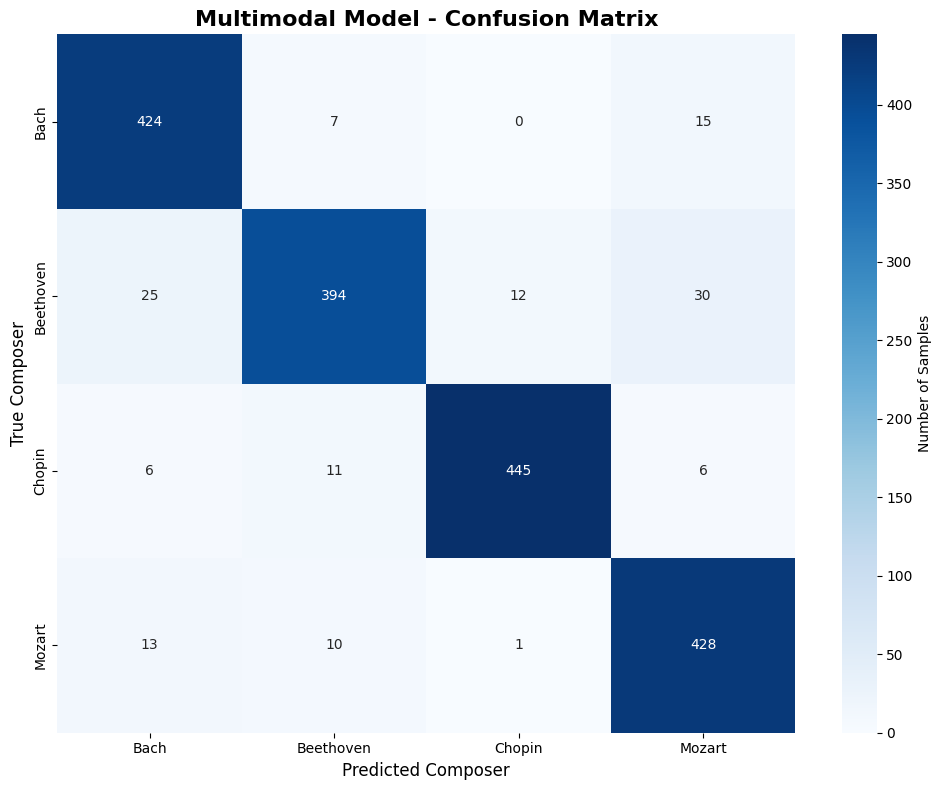


🎯 PER-CLASS ACCURACY:
Bach        : 0.9507 (95.07%)
Beethoven   : 0.8547 (85.47%)
Chopin      : 0.9509 (95.09%)
Mozart      : 0.9469 (94.69%)

🏆 OVERALL ACCURACY: 0.9256 (92.56%)

❌ MOST CONFUSED PAIRS:
Beethoven → Mozart: 30 samples
Beethoven → Bach: 25 samples
Bach → Mozart: 15 samples
Mozart → Bach: 13 samples
Beethoven → Chopin: 12 samples


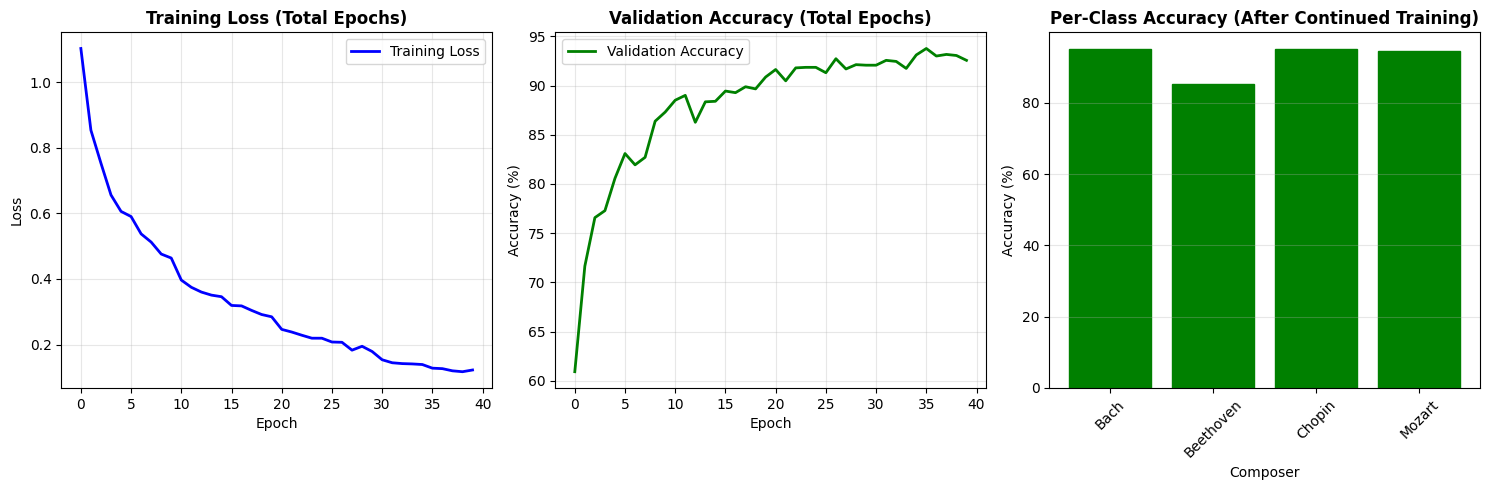


✅ EVALUATION AFTER CONTINUED TRAINING COMPLETE!
🎯 Final Validation Accuracy: 93.76%
🏆 Best Performing Composer: Chopin
📉 Most Challenging Composer: Beethoven


In [ ]:
# # Run evaluation again after continued training
# print("🚀 STARTING COMPREHENSIVE EVALUATION AFTER CONTINUED TRAINING...")
# evaluation_results_continued = evaluate_multimodal_model(model, val_loader, TARGET_COMPOSERS)

# # Plot updated training curves (including continued training)
# plt.figure(figsize=(15, 5))

# # Training Loss
# plt.subplot(1, 3, 1)
# plt.plot(train_losses, 'b-', linewidth=2, label='Training Loss')
# plt.title('Training Loss (Total Epochs)', fontweight='bold')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.grid(True, alpha=0.3)
# plt.legend()

# # Validation Accuracy
# plt.subplot(1, 3, 2)
# plt.plot(val_accuracies, 'g-', linewidth=2, label='Validation Accuracy')
# plt.title('Validation Accuracy (Total Epochs)', fontweight='bold')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.grid(True, alpha=0.3)
# plt.legend()

# # Final Accuracy Bar Chart (using results from continued training)
# plt.subplot(1, 3, 3)
# bars = plt.bar(TARGET_COMPOSERS, evaluation_results_continued['class_accuracies'] * 100)
# plt.title('Per-Class Accuracy (After Continued Training)', fontweight='bold')
# plt.xlabel('Composer')
# plt.ylabel('Accuracy (%)')
# plt.xticks(rotation=45)
# plt.grid(True, alpha=0.3, axis='y')

# # Color bars based on performance (using results from continued training)
# for i, bar in enumerate(bars):
#     accuracy = evaluation_results_continued['class_accuracies'][i]
#     if accuracy > 0.85: # Adjusted threshold slightly for potentially higher performance
#         bar.set_color('green')
#     elif accuracy > 0.7:
#         bar.set_color('orange')
#     else:
#         bar.set_color('red')

# plt.tight_layout()
# plt.show()

# print("\n✅ EVALUATION AFTER CONTINUED TRAINING COMPLETE!")
# print(f"🎯 Final Validation Accuracy: {max(val_accuracies):.2f}%") # Use max from combined list
# print(f"🏆 Best Performing Composer: {TARGET_COMPOSERS[np.argmax(evaluation_results_continued['class_accuracies'])]}")
# print(f"📉 Most Challenging Composer: {TARGET_COMPOSERS[np.argmin(evaluation_results_continued['class_accuracies'])]}")

In [ ]:
# # =====================================================
# # SAVE THE CONTINUED TRAINED MODEL
# # =====================================================

# # Define the path to save the model with _continued in the name
# model_save_path_continued = 'multimodal_lstm_composer_classifier_continued.pth'

# # Save the model's state dictionary
# torch.save(model.state_dict(), model_save_path_continued)

# print(f"✅ Model saved successfully to {model_save_path_continued}")

✅ Model saved successfully to multimodal_lstm_composer_classifier_continued.pth


In [ ]:
# # Instantiate a new model for the original trained model
# original_model = MultimodalComposerClassifier(
#     num_classes=4,
#     num_features=num_features # Use the same number of features as before
# ).to(device)

# # Define the path to the saved original model file
# original_model_path = 'multimodal_lstm_composer_classifier.pth'

# # Load the state dictionary
# original_model.load_state_dict(torch.load(original_model_path, map_location=device))

# print(f"✅ Original multimodal model loaded successfully from {original_model_path}")

✅ Original multimodal model loaded successfully from multimodal_lstm_composer_classifier.pth


In [20]:
# =====================================================
# MULTIMODAL CNN-MLP FUSION ARCHITECTURE WITH LSTM (FIXED)
# =====================================================

class MultimodalComposerClassifierLSTM(nn.Module):
    """
    Multimodal architecture combining CNN (piano rolls) + LSTM + MLP (musical features)
    """
    def __init__(self, num_classes=4, num_features=None, lstm_hidden=128, lstm_layers=1):
        super(MultimodalComposerClassifierLSTM, self).__init__()

        # CNN Stream for Piano Rolls (visual patterns)
        self.cnn_blocks = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(32, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
            nn.MaxPool2d(kernel_size=(2, 2)),

            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=(3, 3), padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.4),
            nn.MaxPool2d(kernel_size=(2, 2))
        )
        # After 3 MaxPool2d(2,2): input (1,128,T) -> (128, 16, T//8)
        # We'll treat width (T//8) as sequence, and (channels*height) as features

        self.lstm_hidden = lstm_hidden
        self.lstm_layers = lstm_layers

        # LSTM expects input: (batch, seq_len, feature_dim)
        # feature_dim = channels * height = 128 * 16 = 2048
        self.lstm = nn.LSTM(
            input_size=128*16,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=False
        )

        # MLP Stream for Musical Features (hand-crafted features)
        self.mlp_stream = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.1)
        )

        # Fusion Layer (combine both streams)
        self.fusion = nn.Sequential(
            nn.Linear(lstm_hidden + 32, 256),  # LSTM output + MLP output
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes)
        )

    def forward(self, piano_roll, features):
        # CNN stream processes piano rolls
        x = self.cnn_blocks(piano_roll)  # (batch, 128, 16, T//8)
        batch, channels, height, width = x.shape  # (B, 128, 16, T//8)
        # Prepare for LSTM: (batch, width, channels*height)
        x = x.permute(0, 3, 1, 2).reshape(batch, width, channels * height)  # (B, seq_len, feature_dim)

        lstm_out, _ = self.lstm(x)
        lstm_feat = lstm_out[:, -1, :]  # Take last output

        # MLP stream processes musical features
        mlp_features = self.mlp_stream(features)

        # Concatenate both feature streams
        combined = torch.cat([lstm_feat, mlp_features], dim=1)

        # Final classification
        output = self.fusion(combined)

        return output

print("🏗️ Multimodal Architecture with LSTM Defined!")
print("• CNN Stream: Processes piano roll visual patterns")
print("• LSTM: Captures temporal dependencies in CNN features")
print("• MLP Stream: Processes hand-crafted musical features")
print("• Fusion Layer: Combines both streams for classification")

🏗️ Multimodal Architecture with LSTM Defined!
• CNN Stream: Processes piano roll visual patterns
• LSTM: Captures temporal dependencies in CNN features
• MLP Stream: Processes hand-crafted musical features
• Fusion Layer: Combines both streams for classification


LSTM Model parameters: 1,499,396
🚀 Starting LSTM multimodal training...
[LSTM] Epoch [1/35], Loss: 1.0873, Val Acc: 65.74%
[LSTM] Epoch [2/35], Loss: 0.8450, Val Acc: 72.47%
[LSTM] Epoch [3/35], Loss: 0.7616, Val Acc: 75.15%
[LSTM] Epoch [4/35], Loss: 0.6951, Val Acc: 76.68%
[LSTM] Epoch [5/35], Loss: 0.6592, Val Acc: 79.31%
[LSTM] Epoch [6/35], Loss: 0.6160, Val Acc: 80.19%
[LSTM] Epoch [7/35], Loss: 0.5859, Val Acc: 80.46%
[LSTM] Epoch [8/35], Loss: 0.5543, Val Acc: 82.98%
[LSTM] Epoch [9/35], Loss: 0.5325, Val Acc: 84.46%
[LSTM] Epoch [10/35], Loss: 0.5198, Val Acc: 84.24%
[LSTM] Epoch [11/35], Loss: 0.4765, Val Acc: 85.22%
[LSTM] Epoch [12/35], Loss: 0.4687, Val Acc: 84.62%
[LSTM] Epoch [13/35], Loss: 0.4499, Val Acc: 85.77%
[LSTM] Epoch [14/35], Loss: 0.4258, Val Acc: 84.95%
[LSTM] Epoch [15/35], Loss: 0.4240, Val Acc: 85.60%
[LSTM] Epoch [16/35], Loss: 0.4316, Val Acc: 85.82%
[LSTM] Epoch [17/35], Loss: 0.3988, Val Acc: 86.54%
[LSTM] Epoch [18/35], Loss: 0.4041, Val Acc: 86.64%
[

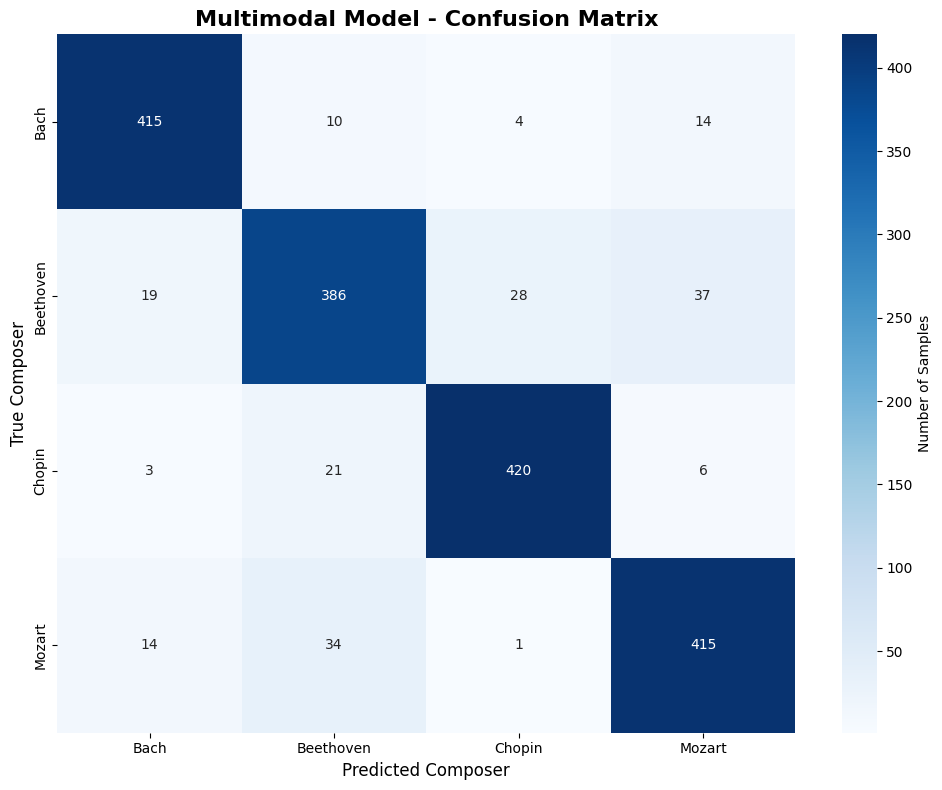


🎯 PER-CLASS ACCURACY:
Bach        : 0.9368 (93.68%)
Beethoven   : 0.8213 (82.13%)
Chopin      : 0.9333 (93.33%)
Mozart      : 0.8944 (89.44%)

🏆 OVERALL ACCURACY: 0.8955 (89.55%)

❌ MOST CONFUSED PAIRS:
Beethoven → Mozart: 37 samples
Mozart → Beethoven: 34 samples
Beethoven → Chopin: 28 samples
Chopin → Beethoven: 21 samples
Beethoven → Bach: 19 samples


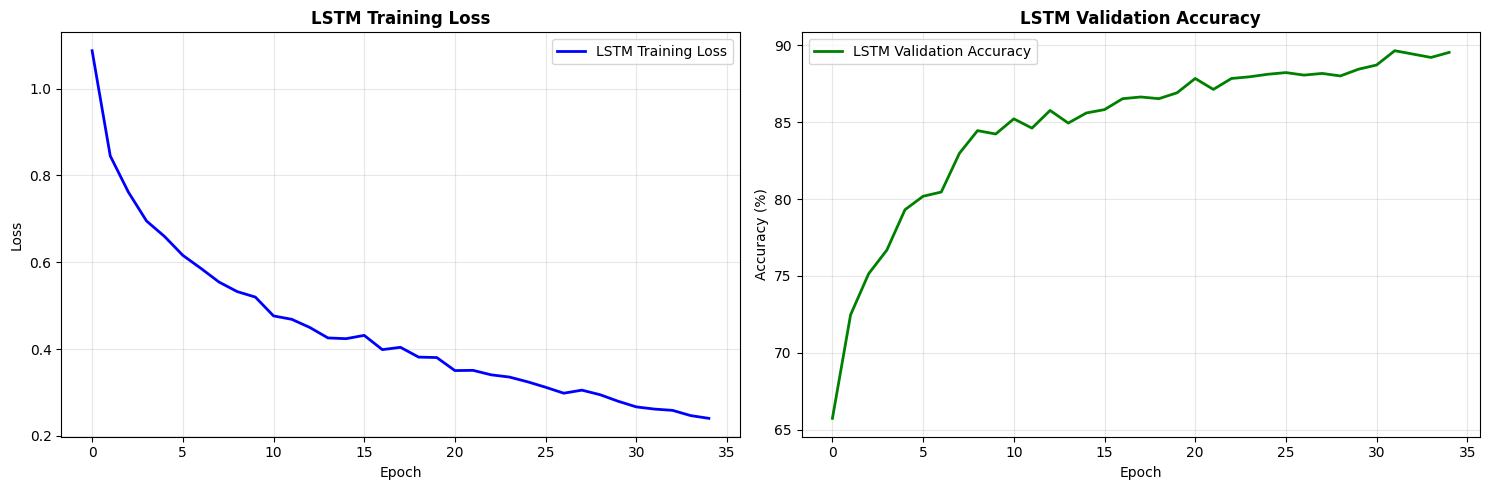

In [23]:
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

train_size = int(0.8 * len(multimodal_dataset))
val_size = len(multimodal_dataset) - train_size
train_dataset, val_dataset = random_split(multimodal_dataset, [train_size, val_size])

num_features = len(comprehensive_features[0])  # Number of musical features
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Train and evaluate the LSTM-based multimodal model

# Instantiate the LSTM model
lstm_model = MultimodalComposerClassifierLSTM(
    num_classes=4,
    num_features=num_features  # Use same as before
).to(device)

print(f"LSTM Model parameters: {sum(p.numel() for p in lstm_model.parameters()):,}")

# Use the same optimizer, criterion, and scheduler as before
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001, weight_decay=1e-4)
lstm_scheduler = torch.optim.lr_scheduler.StepLR(lstm_optimizer, step_size=10, gamma=0.7)
lstm_criterion = nn.CrossEntropyLoss()

# Training function (reuse, but pass optimizer/scheduler)
def train_lstm_multimodal_model(model, train_loader, val_loader, optimizer, scheduler, criterion, epochs=35):
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for piano_rolls, features, labels in train_loader:
            piano_rolls, features, labels = piano_rolls.to(device), features.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(piano_rolls, features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Validation
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():
            for piano_rolls, features, labels in val_loader:
                piano_rolls, features, labels = piano_rolls.to(device), features.to(device), labels.to(device)
                outputs = model(piano_rolls, features)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        avg_loss = epoch_loss / len(train_loader)

        train_losses.append(avg_loss)
        val_accuracies.append(val_accuracy)

        print(f'[LSTM] Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

        scheduler.step()

    return train_losses, val_accuracies

print("🚀 Starting LSTM multimodal training...")
lstm_train_losses, lstm_val_accuracies = train_lstm_multimodal_model(
    lstm_model, train_loader, val_loader, lstm_optimizer, lstm_scheduler, lstm_criterion, epochs=35
)

# Evaluate
print("🚀 Evaluating LSTM multimodal model...")
lstm_evaluation_results = evaluate_multimodal_model(lstm_model, val_loader, TARGET_COMPOSERS)

# Plot training curves for LSTM model
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_train_losses, 'b-', linewidth=2, label='LSTM Training Loss')
plt.title('LSTM Training Loss', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_val_accuracies, 'g-', linewidth=2, label='LSTM Validation Accuracy')
plt.title('LSTM Validation Accuracy', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
# =====================================================
# SAVE THE TRAINED LSTM MODEL
# =====================================================

# Define the path to save the model
lstm_model_save_path = 'multimodal_lstm_composer_classifier.pth'

# Save the model's state dictionary
torch.save(lstm_model.state_dict(), lstm_model_save_path)

print(f"✅ LSTM model saved successfully to {lstm_model_save_path}")

✅ LSTM model saved successfully to multimodal_lstm_composer_classifier.pth


🚀 Continuing LSTM multimodal training for 15 more epochs...
[LSTM] Epoch [1/15], Loss: 0.2351, Val Acc: 89.27%
[LSTM] Epoch [2/15], Loss: 0.2374, Val Acc: 89.44%
[LSTM] Epoch [3/15], Loss: 0.2295, Val Acc: 89.93%
[LSTM] Epoch [4/15], Loss: 0.2240, Val Acc: 89.82%
[LSTM] Epoch [5/15], Loss: 0.2210, Val Acc: 90.15%
[LSTM] Epoch [6/15], Loss: 0.1969, Val Acc: 89.87%
[LSTM] Epoch [7/15], Loss: 0.1966, Val Acc: 89.60%
[LSTM] Epoch [8/15], Loss: 0.1950, Val Acc: 90.09%
[LSTM] Epoch [9/15], Loss: 0.1862, Val Acc: 89.82%
[LSTM] Epoch [10/15], Loss: 0.1762, Val Acc: 89.66%
[LSTM] Epoch [11/15], Loss: 0.1802, Val Acc: 89.87%
[LSTM] Epoch [12/15], Loss: 0.1746, Val Acc: 90.31%
[LSTM] Epoch [13/15], Loss: 0.1739, Val Acc: 89.98%
[LSTM] Epoch [14/15], Loss: 0.1689, Val Acc: 89.49%
[LSTM] Epoch [15/15], Loss: 0.1759, Val Acc: 90.15%

✅ Continued LSTM Training Complete!
🔍 EVALUATING MULTIMODAL MODEL...

📊 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

        Bach     0

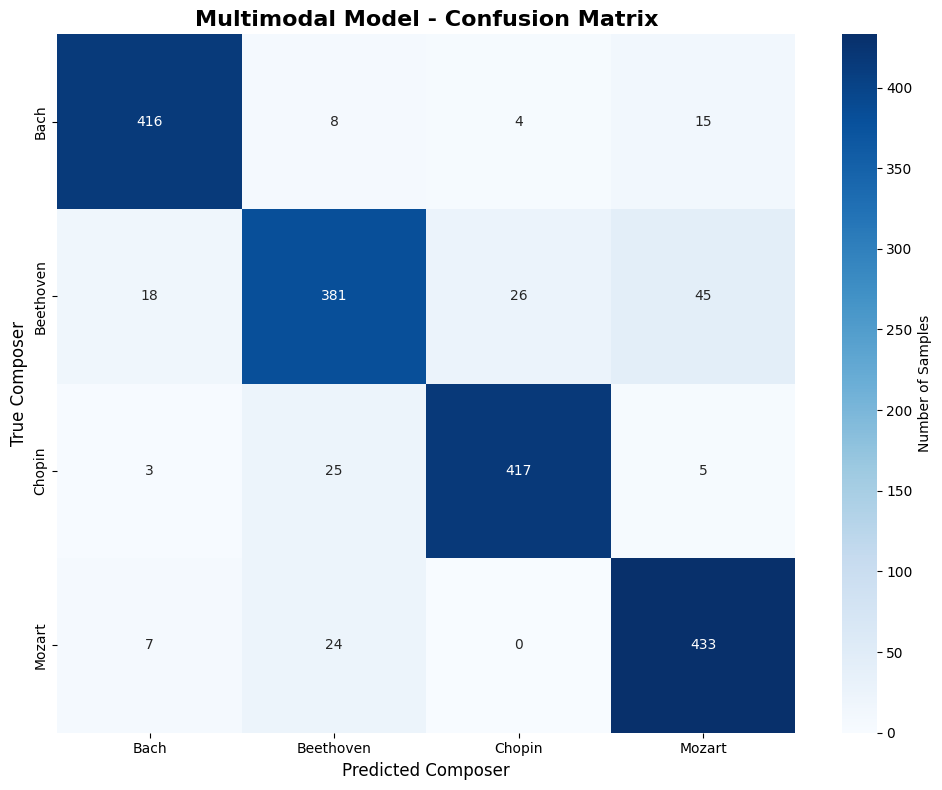


🎯 PER-CLASS ACCURACY:
Bach        : 0.9391 (93.91%)
Beethoven   : 0.8106 (81.06%)
Chopin      : 0.9267 (92.67%)
Mozart      : 0.9332 (93.32%)

🏆 OVERALL ACCURACY: 0.9015 (90.15%)

❌ MOST CONFUSED PAIRS:
Beethoven → Mozart: 45 samples
Beethoven → Chopin: 26 samples
Chopin → Beethoven: 25 samples
Mozart → Beethoven: 24 samples
Beethoven → Bach: 18 samples


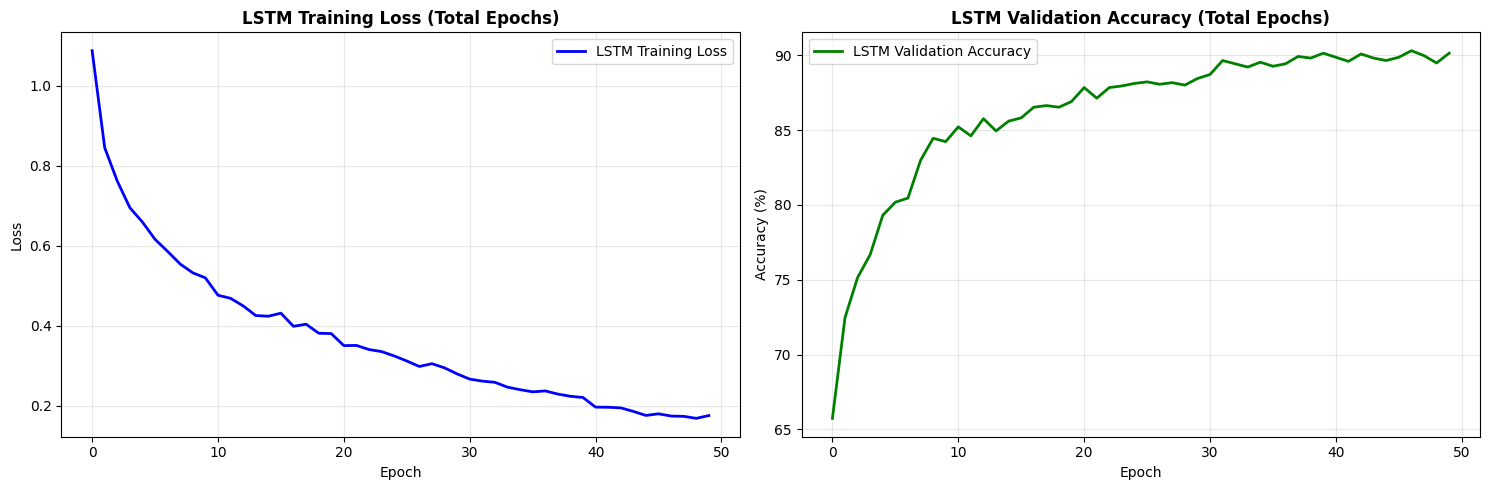

In [25]:
# Continue training the LSTM-based multimodal model for more epochs

print("🚀 Continuing LSTM multimodal training for 15 more epochs...")

# Continue training using the same function and optimizer/scheduler
lstm_train_losses_cont, lstm_val_accuracies_cont = train_lstm_multimodal_model(
    lstm_model, train_loader, val_loader, lstm_optimizer, lstm_scheduler, lstm_criterion, epochs=15
)

# Append new history for plotting
lstm_train_losses.extend(lstm_train_losses_cont)
lstm_val_accuracies.extend(lstm_val_accuracies_cont)

print("\n✅ Continued LSTM Training Complete!")

# Optionally, re-evaluate and plot updated curves
lstm_evaluation_results_continued = evaluate_multimodal_model(lstm_model, val_loader, TARGET_COMPOSERS)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(lstm_train_losses, 'b-', linewidth=2, label='LSTM Training Loss')
plt.title('LSTM Training Loss (Total Epochs)', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_val_accuracies, 'g-', linewidth=2, label='LSTM Validation Accuracy')
plt.title('LSTM Validation Accuracy (Total Epochs)', fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()